In [1]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.time import Time

# set default font size in matplotlib
plt.rcParams.update({'font.size': 12})

In [2]:
full_integration_fluxes = pd.read_csv('../data/Stokes_I_fluxes.csv')

# calculate the mean time between tstart and tstop, first convert to datetime
full_integration_fluxes['tstart'] = pd.to_datetime(full_integration_fluxes['tstart'], format='%H:%M:%S')
full_integration_fluxes['tstop'] = pd.to_datetime(full_integration_fluxes['tstop'], format='%H:%M:%S')

# calculate the mean time between tstart and tstop
timedelta = full_integration_fluxes['tstop'] - full_integration_fluxes['tstart']
full_integration_fluxes['mean_time'] = full_integration_fluxes['tstart'] + timedelta / 2

# convert obsname YYYYMMDD  and mean_time combined to datetime
full_integration_fluxes['obsname'] = pd.to_datetime(full_integration_fluxes['obsname'], format='%Y%m%d')
full_integration_fluxes['datetime'] = full_integration_fluxes['obsname'] + pd.to_timedelta(full_integration_fluxes['mean_time'].dt.strftime('%H:%M:%S'))

# delete mean_time column
full_integration_fluxes = full_integration_fluxes.drop(columns=['mean_time'])

# convert tstart and tstop to just times
full_integration_fluxes['tstart'] = full_integration_fluxes['tstart'].dt.strftime('%H:%M:%S')
full_integration_fluxes['tstop'] = full_integration_fluxes['tstop'].dt.strftime('%H:%M:%S')

# convert datetime to jd
full_integration_fluxes['jd'] = Time(full_integration_fluxes["datetime"], scale='utc').jd


full_integration_fluxes

,obsname,tstart,tstop,source_J,bkg_rms_J,bkg_max_J,datetime,jd
0,2024-04-07,09:10:29,20:19:49,0.000084,0.000024,0.000167,2024-04-07 14:45:09,2.460408e+06
1,2024-04-21,08:39:19,16:41:39,0.000189,0.000028,0.000130,2024-04-21 12:40:29,2.460422e+06
2,2024-04-26,08:45:59,19:35:49,0.000238,0.000024,0.000126,2024-04-26 14:10:54,2.460427e+06
3,2024-04-28,13:03:49,18:10:19,0.000117,0.000052,0.000174,2024-04-28 15:37:04,2.460429e+06
4,2024-05-05,13:13:49,18:39:59,0.000273,0.000033,0.000151,2024-05-05 15:56:54,2.460436e+06
5,2024-05-11,06:59:59,18:14:59,0.000382,0.000023,0.000124,2024-05-11 12:37:29,2.460442e+06
6,2024-05-15,06:37:29,17:54:19,0.000207,0.000022,0.000108,2024-05-15 12:15:54,2.460446e+06
7,2024-05-31,05:24:09,16:35:09,0.000084,0.000017,0.000080,2024-05-31 10:59:39,2.460462e+06
8,2024-06-11,06:09:39,12:13:59,0.000698,0.000140,0.000144,2024-06-11 09:11:49,2.460473e+06
9,2024-06-14,04:28:29,15:48:49,0.000331,0.000015,0.000116,2024-06-14 10:08:39,2.460476e+06


In [3]:
# READ IN ALL THE TIMESERIES ---------------------------------------------------

# search /home/ilin/Documents/2024_04_HIP67522_ATCA/results for all timeseries.csv files, including subdirectories
files = glob.glob('/home/ilin/Documents/2024_04_HIP67522_ATCA/results/**/timeseries/timeseries.csv', recursive=True)

# write all files to a single dataframe
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)


# DO A BUNCH OF TIME CONVERSIONS -----------------------------------------------

# search the same folder for all instances of start.txt
start_files = glob.glob('/home/ilin/Documents/2024_04_HIP67522_ATCA/results/**/timeseries/tstart.txt', recursive=True)

# for each tstart.txt file read in the start time and the obsname from the file path and put them in a dictionary
obs_dict = {}
for file in start_files:
    with open(file, 'r') as f:
        obsname = file.split('/')[-3]
        start = f.read().strip()
        obs_dict[int(obsname)] = start


# add the start time to the dataframe
df['tstart'] = df['obsname'].map(obs_dict)

# convert obsname and num to date and time column
df['date'] = pd.to_datetime(df['obsname'], format='%Y%m%d')


df['time'] = pd.to_datetime(df['num'].astype(str) + df["tstart"].apply(lambda x: x[2:])).dt.time

# combine date and time into a single column
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

# convert the UTC to JD
df['jd'] = Time(df['datetime'], scale="utc").jd

print(Time(df['datetime'], scale="utc").scale)

print((df["jd"] - 2400000.5).min())

# if source_J is < than 3 * bkg_rms_J, set it to 3 * bkg_rms_J and upper limit the error bar
df['source_J_val'] = df["source_J"] > (3 * df["bkg_rms_J"]) 

# CALCULATE ORBITAL PHASE ------------------------------------------------------

# read HIP 67522 params from /home/ilin/Documents/2024_03_HIP67522_Paper/HIP67522-Paper/src/data/hip67522_params.csv
hip67522_params = pd.read_csv('../data/hip67522_params.csv')
period = hip67522_params.loc[hip67522_params.param == "orbper_d","val"].values[0]
midpoint = hip67522_params.loc[hip67522_params.param == "midpoint_BJD","val"].values[0]
prot = 1.4145 #mean val from TESS AND CHEOPS


# convert JD to phase
df['phase'] = np.mod(df['jd'] - midpoint, period) / period
df['rot_phase'] = np.mod(df['jd'] - midpoint, prot) / prot
df[["date", "jd", "tstart","datetime"]].iloc[:17]


# convert jd to phase for full_integration_fluxes
full_integration_fluxes['phase'] = np.mod(full_integration_fluxes['jd'] - midpoint, period) / period
full_integration_fluxes['rot_phase'] = np.mod(full_integration_fluxes['jd'] - midpoint, prot) / prot
full_integration_fluxes['source_J_val'] = full_integration_fluxes["source_J"] > (4 * full_integration_fluxes["bkg_rms_J"])

ValueError: invalid literal for int() with base 10: '20240611old'

In [44]:
df.to_csv('../data/all_timeseries.csv', index=False)

(0.0, 1.0)

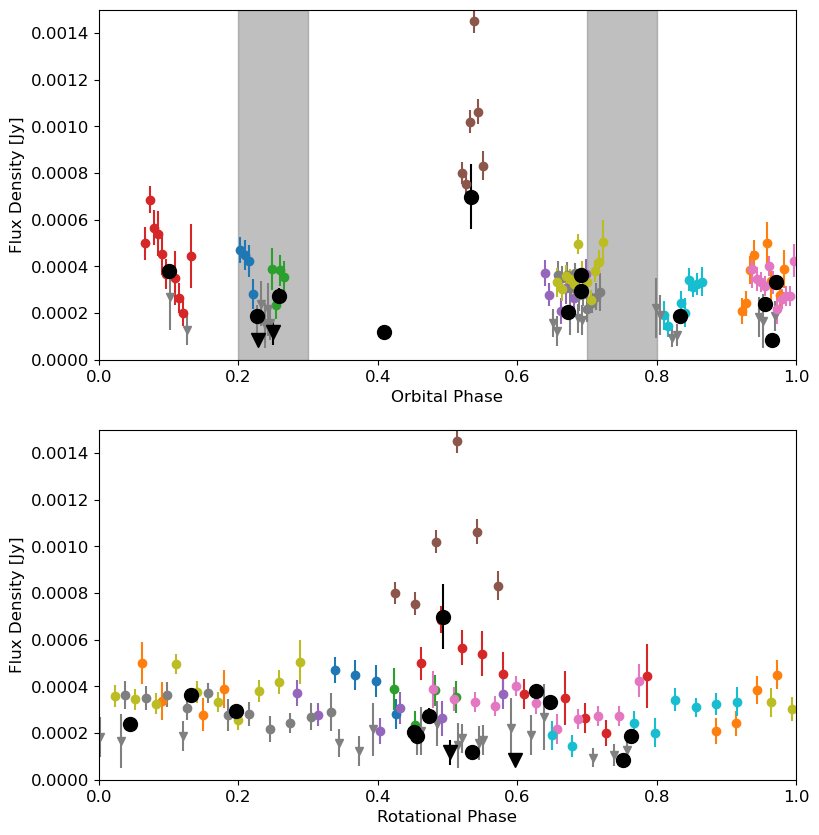

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(9, 10))
versions = [("Orbital", "phase", axs[0]), ("Rotational", "rot_phase", axs[1])]
 

for version, phase, ax in versions:
    # plot the flux density vs time
    

    for obsname, g in df.groupby('obsname'):
        g1 = g[g['source_J_val']]
        ax.errorbar(g1[phase], g1['source_J'], yerr=g1['bkg_rms_J'], fmt='o', label=obsname)
        g2 = g[~g['source_J_val']]
        ax.errorbar(g2[phase], g2['source_J'], yerr=g2['bkg_rms_J'], fmt='v', color="grey", label=obsname)

    # plot the full integration fluxes
    f1 = full_integration_fluxes[full_integration_fluxes['source_J_val']]
    ax.errorbar(f1[phase], f1['source_J'], yerr=f1['bkg_rms_J'], fmt='o', c="k", markersize=10)
    f2 = full_integration_fluxes[~full_integration_fluxes['source_J_val']]
    ax.errorbar(f2[phase], f2['source_J'], yerr=f2['bkg_rms_J'], fmt='v', color="k", markersize=10)

    if version == "Orbital":
        ax.fill_betweenx([0, 1.5e-3], 0.2, 0.3, color='gray', alpha=0.5)
        ax.fill_betweenx([0, 1.5e-3], 0.7, 0.8, color='gray', alpha=0.5)
        
    ax.set_xlabel(f'{version} Phase')
    ax.set_ylabel('Flux Density [Jy]')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1.5e-3)

plt.savefig(f'../plots/phase_flux_density.png', dpi=300)

plt.xlim(0.,1)

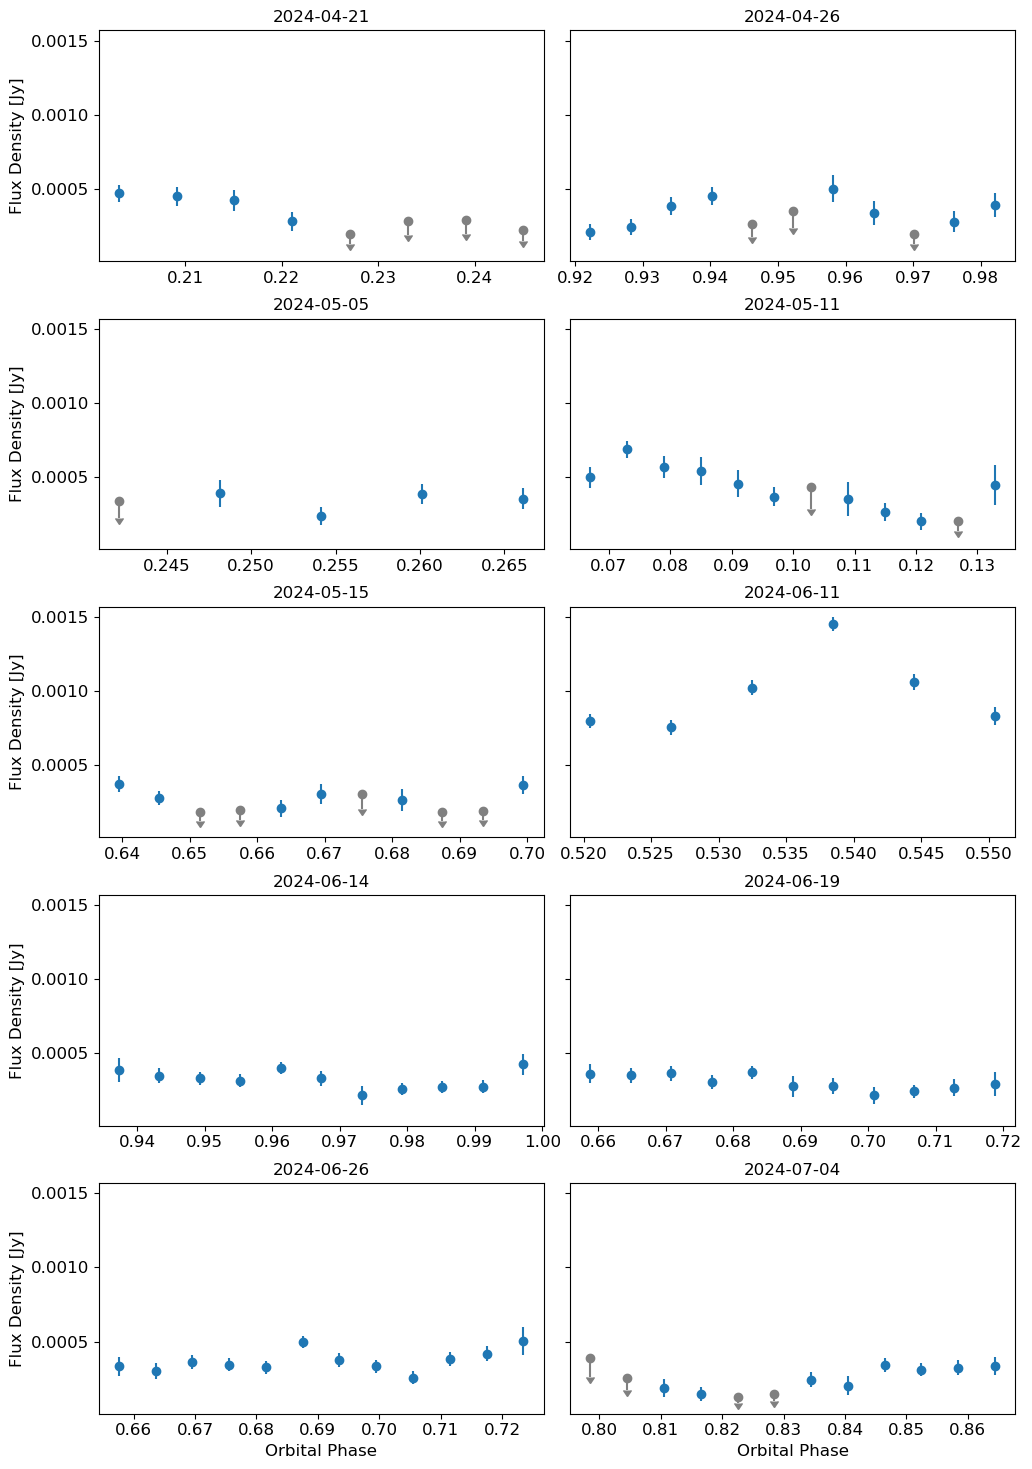

In [14]:

# rewrite the above for a vertical 3 x 5 grid of subplots
fig, axs = plt.subplots(5, 2, figsize=(21/2, 29.7/2), sharey=True)




axs = axs.flatten()

for i, (obsname, group) in enumerate(df.groupby('obsname')):
    ax = axs[i]
    g1 = group[group["source_J_val"]]
    ax.errorbar(g1['phase'], g1['source_J'], yerr=g1['bkg_rms_J'], fmt='o')
    g2 = group[~group["source_J_val"]]
    ax.errorbar(g2['phase'], 3 * g2['bkg_rms_J'], yerr=g2['bkg_rms_J'], fmt='o', color="grey", uplims=True)
    ax.set_title(group["date"].iloc[0].date(), fontsize=12)
    
    
# set x-labels for the bottom row
for ax in axs[-2:]:
    ax.set_xlabel('Orbital Phase')

# set y-labels for the left column
for ax in axs[::2]:
    ax.set_ylabel('Flux Density [Jy]')

plt.tight_layout()

# reduce vertical spacing between subplots
plt.subplots_adjust(hspace=0.25)
plt.subplots_adjust(wspace=0.06)

plt.savefig(f'../plots/orbital_phase_flux_density_grid.png', dpi=300)

Text(0, 0.5, 'Flux Density [Jy]')

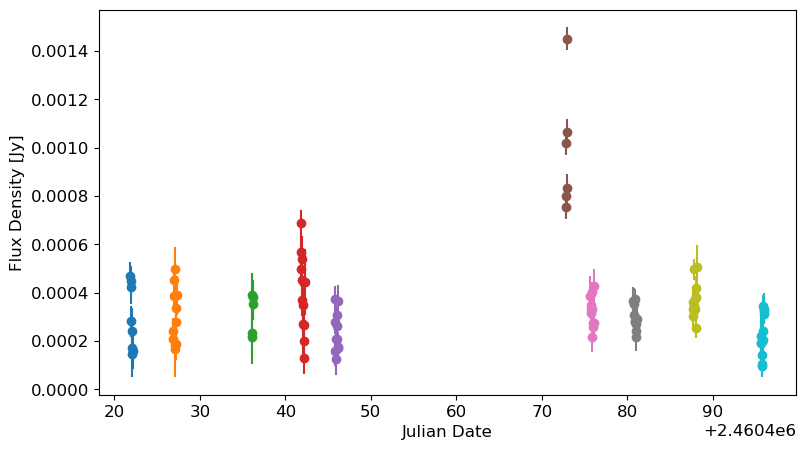

In [6]:
# plot a full time series of the radio data
fig, ax = plt.subplots(figsize=(9, 5))

for obsname, group in df.groupby('obsname'):
    ax.errorbar(group['jd'], group['source_J'], yerr=group['bkg_rms_J'], fmt='o', label=obsname)

ax.set_xlabel('Julian Date')
ax.set_ylabel('Flux Density [Jy]')
